In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp
import warnings
warnings.filterwarnings(action='ignore')

C:\ana3\envs\t_f2.2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ana3\envs\t_f2.2\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ana3\envs\t_f2.2\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def price_data(start,end):
    #Korea stock
    KODEX_200 = web.DataReader('069500.KS',data_source='yahoo',start=start,end=end)
    KOSDAQ_150 = web.DataReader('229200.KS',data_source='yahoo',start=start,end=end)
    KODEX_LVERAGE = web.DataReader('122630.KS',data_source='yahoo',start=start,end=end)
    KODEX_KOSDAQ_150_LVERAGE = web.DataReader('233740.KS',data_source='yahoo',start=start,end=end)
    KODEX_SAMSUNG = web.DataReader('102780.KS',data_source='yahoo',start=start,end=end)
    TIGER_TOP10 = web.DataReader('292150.KS',data_source='yahoo',start=start,end=end)


    #Korea bond
    KODEX_10Y = web.DataReader('152380.KS',data_source='yahoo',start=start,end=end)
    KODEX_TBS_3Y = web.DataReader('114260.KS',data_source='yahoo',start=start,end=end)
    KODEX_KRW_CASH = web.DataReader('153130.KS',data_source='yahoo',start=start,end=end)
    KODEX_KRW_CASH_PLUS = web.DataReader('130730.KS',data_source='yahoo',start=start,end=end)  # kosef-130730
    TIGER_MONEY_MARKET = web.DataReader('157450.KS',data_source='yahoo',start=start,end=end)
    KIWOOM_10Y = web.DataReader('148070.KS',data_source='yahoo',start=start,end=end)

    #price_data
    close_df = pd.DataFrame({'bond_1':KODEX_10Y['Adj Close'],
                             'bond_2':KODEX_TBS_3Y['Adj Close'],
                             'bond_3':KODEX_KRW_CASH['Adj Close'],
                             'bond_4':KODEX_KRW_CASH_PLUS['Adj Close'],  
                             'bond_5':TIGER_MONEY_MARKET['Adj Close'],
                             'bond_6':KIWOOM_10Y['Adj Close'],  
                             'stock_1':KODEX_200['Adj Close'],
                             'stock_2':KOSDAQ_150['Adj Close'],
                             'stock_3':KODEX_SAMSUNG['Adj Close'],
                             'stock_4':KODEX_KOSDAQ_150_LVERAGE['Adj Close'],
                             'stock_5':KODEX_LVERAGE['Adj Close'],
                             'stock_6':TIGER_TOP10['Adj Close']})

    close_df.drop(index=close_df.iloc[:1, :].index.tolist(), inplace=True)
    return close_df

In [3]:
def calculate_gain(investment_amount, weight, close_df):
    
    portfolio_amount = []
    for w in weight:
        portfolio_amount.append(investment_amount*w)

    gain_list = []
    for i in range(12):
        gap_price = close_df.iloc[-1][i] - close_df.iloc[0][i]
        rtn_pct = gap_price / close_df.iloc[0][i]
        gain_list.append((1+rtn_pct)*portfolio_amount[i])
    all_gain = 0
    for rtn in gain_list:
        all_gain += rtn
        
    return all_gain

In [4]:
def calculate_mu_sigma(start,end):
    #Korea stock
    KODEX_200 = web.DataReader('069500.KS',data_source='yahoo',start=start,end=end)
    KOSDAQ_150 = web.DataReader('229200.KS',data_source='yahoo',start=start,end=end)
    KODEX_LVERAGE = web.DataReader('122630.KS',data_source='yahoo',start=start,end=end)
    KODEX_KOSDAQ_150_LVERAGE = web.DataReader('233740.KS',data_source='yahoo',start=start,end=end)
    KODEX_SAMSUNG = web.DataReader('102780.KS',data_source='yahoo',start=start,end=end)
    TIGER_TOP10 = web.DataReader('292150.KS',data_source='yahoo',start=start,end=end)

    #Korea bond
    KODEX_10Y = web.DataReader('152380.KS',data_source='yahoo',start=start,end=end)
    KODEX_TBS_3Y = web.DataReader('114260.KS',data_source='yahoo',start=start,end=end)
    KODEX_KRW_CASH = web.DataReader('153130.KS',data_source='yahoo',start=start,end=end)
    KODEX_KRW_CASH_PLUS = web.DataReader('130730.KS',data_source='yahoo',start=start,end=end)
    TIGER_MONEY_MARKET = web.DataReader('157450.KS',data_source='yahoo',start=start,end=end)
    KIWOOM_10Y = web.DataReader('148070.KS',data_source='yahoo',start=start,end=end)
    
    
    # change into monthly data
    
    #Korea stock
    KODEX_200 = pd.DataFrame(KODEX_200.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    KOSDAQ_150 = pd.DataFrame(KOSDAQ_150.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    KODEX_LVERAGE = pd.DataFrame(KODEX_LVERAGE.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    KODEX_KOSDAQ_150_LVERAGE = pd.DataFrame(KODEX_KOSDAQ_150_LVERAGE.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    KODEX_SAMSUNG = pd.DataFrame(KODEX_SAMSUNG.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    TIGER_TOP10 = pd.DataFrame(TIGER_TOP10.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    
    #Korea bond
    KODEX_10Y = pd.DataFrame(KODEX_10Y.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    KODEX_TBS_3Y = pd.DataFrame(KODEX_TBS_3Y.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    KODEX_KRW_CASH = pd.DataFrame(KODEX_KRW_CASH.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    KODEX_KRW_CASH_PLUS = pd.DataFrame(KODEX_KRW_CASH_PLUS.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    TIGER_MONEY_MARKET = pd.DataFrame(TIGER_MONEY_MARKET.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())
    KIWOOM_10Y = pd.DataFrame(KIWOOM_10Y.groupby(pd.Grouper(freq='M'))['Adj Close'].mean())


    ### calculate return
    KODEX_200_logret = np.log(KODEX_200['Adj Close']/KODEX_200['Adj Close'].shift(1))
    KOSDAQ_150_logret = np.log(KOSDAQ_150['Adj Close']/KOSDAQ_150['Adj Close'].shift(1))
    KODEX_LVERAGE_logret = np.log(KODEX_LVERAGE['Adj Close']/KODEX_LVERAGE['Adj Close'].shift(1))
    KODEX_KOSDAQ_150_LVERAGE_logret = np.log(KODEX_KOSDAQ_150_LVERAGE['Adj Close']/KODEX_KOSDAQ_150_LVERAGE['Adj Close'].shift(1))
    KODEX_SAMSUNG_logret = np.log(KODEX_SAMSUNG['Adj Close']/KODEX_SAMSUNG['Adj Close'].shift(1))
    TIGER_TOP10_logret = np.log(TIGER_TOP10['Adj Close']/TIGER_TOP10['Adj Close'].shift(1))

    
    KODEX_10Y_logret = np.log(KODEX_10Y['Adj Close']/KODEX_10Y['Adj Close'].shift(1))
    KODEX_TBS_logret = np.log(KODEX_TBS_3Y['Adj Close']/KODEX_TBS_3Y['Adj Close'].shift(1))
    KODEX_KRW_CASH_logret = np.log(KODEX_KRW_CASH['Adj Close']/KODEX_KRW_CASH['Adj Close'].shift(1))
    KODEX_KRW_CASH_PLUS_logret = np.log(KODEX_KRW_CASH_PLUS['Adj Close']/KODEX_KRW_CASH_PLUS['Adj Close'].shift(1))    
    TIGER_MONEY_MARKET_logret = np.log(TIGER_MONEY_MARKET['Adj Close']/TIGER_MONEY_MARKET['Adj Close'].shift(1))
    KIWOOM_10Y_logret = np.log(KIWOOM_10Y['Adj Close']/KIWOOM_10Y['Adj Close'].shift(1))   
    
    # concat all data as dataframe
    stock_data = pd.DataFrame({'KODEX':KODEX_200_logret,
                           'KOSDAQ':KOSDAQ_150_logret,
                           'KODEX_SAMSUNG':KODEX_SAMSUNG_logret,
                           'KODEX_KOSDAQ_150_LVERAGE':KODEX_KOSDAQ_150_LVERAGE_logret,
                           'KODEX_LVERAGE':KODEX_LVERAGE_logret,
                           'TIGER_TOP10':TIGER_TOP10_logret})

    stock_data.loc[0:2,list(stock_data.columns)]=0.0 # shift1하면서 생긴 none 데이터 결측치 처리

    bond_data = pd.DataFrame({'KODEX_10Y':KODEX_10Y_logret,
                              'KODEX_TBS':KODEX_TBS_logret,
                              'KODEX_KRW_CASH':KODEX_LVERAGE_logret,
                              'KODEX_KRW_CASH_PLUS':KODEX_KOSDAQ_150_LVERAGE_logret,
                              'TIGER_MONEY_MARKET':KODEX_SAMSUNG_logret,
                              'KIWOOM_10Y':TIGER_TOP10_logret})

    bond_data.loc[0:2,list(bond_data.columns)]=0.0 # shift1하면서 생긴 none 데이터 결측치 처리

    stock_bond_return = pd.concat([stock_data,bond_data],axis=1)

    stock_bond_return.drop(index=stock_bond_return.iloc[:2, :].index.tolist(), inplace=True)
    stock_bond_return.dropna(axis=0, inplace=True)

    mu = stock_bond_return.mean()*3    # 분기별 데이터 사용
    sigma = stock_bond_return.cov()*3   
    #mu = mu.values
    #mu = mu.reshape((8,))
    mu = mu.values.T
    sigma = sigma.values
    
    return mu, sigma

In [5]:
def robust_optimizing(mu,sigma):
    w = cp.Variable(12)
    w_plus = cp.Variable(12)
    w_minus = cp.Variable(12)

    # box uncertainty set
    delta = np.array([0.005,0.005,0.005,0.005,0.005,0.005,0.01,0.01,0.01,0.01,0.01,0.01]).reshape(12,1)

    lambda0 = .1

    ret = mu.T*w
    aux = delta.T * (w_plus + w_minus)
    risk = cp.quad_form(w,sigma)

    objective = cp.Minimize(risk - lambda0*ret + lambda0*aux)

    prob = cp.Problem(objective,
                     [sum(w)==1,
                      w == w_plus - w_minus,
                      w_plus >=0,
                      w_minus>=0,
                      w >= -0.05,    # 공매도는 조금만
                      sum(w[:6]) >= sum(w[6:])*1.7   # 채권 비중이 2배 이상 높다
                     ])

    prob.solve()


    print('\n Robust portfolio model\n')
    print('\n Robust portfolio model\n')
    
    print('expected return',mu.dot(w.value))
    print('standard deviation:',np.sqrt(w.value.dot(sigma).dot(w.value)))
    print('optimal weight\n')
    print('1_bond',w.value[0])
    print('2_bond',w.value[1])
    print('3_bond',w.value[2])
    print('4_bond',w.value[3])
    print('5_bond',w.value[4])
    print('6_bond',w.value[5])
    
    print('1_stock',w.value[6])
    print('2_stock',w.value[7])
    print('3_stock',w.value[8])
    print('4_stock',w.value[9])
    print('5_stock',w.value[10])
    print('6_stock',w.value[11])

    print('\nbond:',sum([w.value[i] for i in range(6)]))
    print('stock:',sum([w.value[i+6] for i in range(6)]))
    
    return w.value

# Simulation

In [18]:
# random returns on bonds and stocks based on 2018,2019 historical data

num_samples = 3
sample_returns = pd.DataFrame()

for i in range(1000):
    
    np.random.seed(i)
    random_returns = np.random.multivariate_normal(mu_0,sigma_0,num_samples).T
    tmp = pd.DataFrame(random_returns).T
    sample_returns = pd.concat([sample_returns,tmp],axis=0)
sample_returns.columns = ['bond1','bond2','bond3','bond4','bond5','bond6',
                          'stock1','stock2','stock3','stock4','stock5','stock6']

In [22]:
sample_returns.head()

,bond1,bond2,bond3,bond4,bond5,bond6,stock1,stock2,stock3,stock4,stock5,stock6
0,-0.098712,-0.258657,-0.119050,-0.536912,-0.171205,-0.110114,0.031085,0.011948,-0.171205,-0.536912,-0.119050,-0.110114
1,-0.050586,-0.147664,-0.059276,-0.318028,-0.095534,-0.051278,0.034136,0.012245,-0.095534,-0.318028,-0.059276,-0.051278
2,-0.170757,-0.259878,-0.176803,-0.560687,-0.347736,-0.193687,0.055195,0.011990,-0.347736,-0.560687,-0.176803,-0.193687
0,-0.134826,-0.227204,-0.106971,-0.460820,-0.240097,-0.115198,0.051997,0.017479,-0.240097,-0.460820,-0.106971,-0.115198
1,-0.013541,-0.032300,-0.023655,-0.069512,-0.012316,0.004452,0.012628,0.003642,-0.012316,-0.069512,-0.023655,0.004452


In [38]:
each_sample_wealth = []
num_samples = len(sample_returns) 
rebalancing_period =4

mu_list = []
volatility_list = []

for i in tqdm(range(num_samples)):
    
    investing_amount = 10000
    mu = (sample_returns.to_numpy()[i])

    for rebalance in range(rebalancing_period):
        investing_amount = investing_amount

        w = cp.Variable(12)
        w_plus = cp.Variable(12)
        w_minus = cp.Variable(12)

        # box uncertainty set
        delta = np.array([0.005,0.005,0.005,0.005,0.005,0.005,0.01,0.01,0.01,0.01,0.01,0.01]).reshape(12,1)

        lambda0 = .1
        ret = mu.T*w
        
        aux = delta.T * (w_plus + w_minus)
        risk = cp.quad_form(w,sigma_0)

        objective = cp.Minimize(risk - lambda0*ret + lambda0*aux)

        prob = cp.Problem(objective,
                         [sum(w)==1,
                          w == w_plus - w_minus,
                          w_plus >=0,
                          w_minus>=0,
                          w >= -0.05,    # 공매도는 조금만
                          sum(w[:6]) >= sum(w[6:])*1.7   # 채권 비중이 1.7배 이상 높다
                          ])
        prob.solve()
        
        #print('expected return',mu.dot(w.value))
        #print('standard deviation:',np.sqrt(w.value.dot(sigma_0).dot(w.value)))
        
        volatility_list.append(np.sqrt(w.value.dot(sigma_0).dot(w.value)))
        mu_list.append(mu.dot(w.value))
        
        investing_amount = np.dot(mu,w.value*investing_amount) + investing_amount
        mu = np.array([np.dot(mu[0],w.value[0]) for i in range(12)])   # rebalancing할 때마다, update
        
    each_sample_wealth.append(investing_amount)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:49<00:00, 17.72it/s]


In [39]:
len(each_sample_wealth)

3000

In [40]:
first_rebalancing_mu = []
second_rebalancing_mu = []
third_rebalancing_mu = []
fourth_rebalancing_mu = []

first_rebalancing_sg = []
second_rebalancing_sg = []
third_rebalancing_sg = []
fourth_rebalancing_sg = []

for i in range(len(mu_list)):
    
    if i%4 == 0:
        first_rebalancing_mu.append(mu_list[i])
        first_rebalancing_sg.append(volatility_list[i])
    
    elif i%4 == 1:
        second_rebalancing_mu.append(mu_list[i])
        second_rebalancing_sg.append(volatility_list[i])
        
    elif i%4 == 2:
        third_rebalancing_mu.append(mu_list[i])
        third_rebalancing_sg.append(volatility_list[i])
        
    elif i%4 == 3:
        fourth_rebalancing_mu.append(mu_list[i])
        fourth_rebalancing_sg.append(volatility_list[i])

In [41]:
# rebalancing 기간별 평균
first_mu = sum(first_rebalancing_mu)/len(first_rebalancing_mu)
second_mu = sum(second_rebalancing_mu)/len(second_rebalancing_mu)
third_mu = sum(third_rebalancing_mu)/len(third_rebalancing_mu)
fourht_mu = sum(fourth_rebalancing_mu)/len(fourth_rebalancing_mu)

first_sg = sum(first_rebalancing_sg)/len(first_rebalancing_sg)
second_sg = sum(second_rebalancing_sg)/len(second_rebalancing_sg)
third_sg = sum(third_rebalancing_sg)/len(third_rebalancing_sg)
fourth_sg = sum(fourth_rebalancing_sg)/len(fourth_rebalancing_sg)

In [42]:
print('first-period average expected return:',first_mu)
print('first-period average standard deviation:',first_sg)
print('\n')

print('second-period average expected return:',second_mu)
print('second-period average standard deviation:',second_sg)
print('\n')

print('third-period average expected return:',third_mu)
print('third-period average standard deviation:',third_sg)
print('\n')

print('fourth-period average expected return:',fourht_mu)
print('fourth-period average standard deviation:',fourth_sg)

first-period average expected return: 0.05792412921447482
first-period average standard deviation: 0.0361550796295948


second-period average expected return: -0.00445583114329965
second-period average standard deviation: 0.017225055626246558


third-period average expected return: -0.002633963576228031
third-period average standard deviation: 0.017225055626246558


fourth-period average expected return: -0.001557007861783189
fourth-period average standard deviation: 0.017225055626246558


In [43]:
average_wealth = sum(each_sample_wealth)/len(each_sample_wealth)
print(average_wealth)

10496.921248752109


Text(0.5, 0, 'total wealth at the end of 2020')

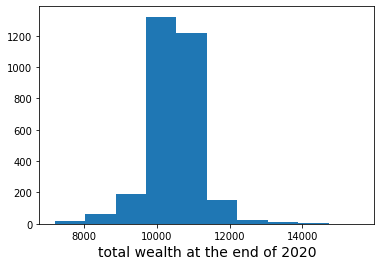

In [44]:
import matplotlib.pyplot as plt

plt.hist(each_sample_wealth)
plt.xlabel('total wealth at the end of 2020',fontsize=14)

# Progress report

#### 1st portfolio selection : investing money on 2020/01/01 with past dat

In [34]:
mu_0, sigma_0 = calculate_mu_sigma(start='1/1/2018',end='12/31/2019')
weight_0 = robust_optimizing(mu_0,sigma_0)     # 2020/01/01 투자 비중


 Robust portfolio model


 Robust portfolio model

expected return 0.024700812325026047
standard deviation: 0.025472203739669824
optimal weight

1_bond -3.241073478541443e-22
2_bond -0.05
3_bond 0.680061009578863
4_bond -0.05
5_bond -0.050000000000000024
6_bond 0.13660565708780392
1_stock 0.5333333333333333
2_stock 9.011191830703347e-22
3_stock -0.050000000000000024
4_stock -0.05000000000000001
5_stock -0.050000000000000024
6_stock -0.05

bond: 0.6666666666666667
stock: 0.33333333333333326


#### 2nd portfolio selection : investing money on 2020/04/01 with past dat

In [35]:
mu_1, sigma_1 = calculate_mu_sigma(start='4/1/2018',end='3/31/2020') 
weight_1 = robust_optimizing(mu_1,sigma_1)    # 2020/04/01 투자 비중


 Robust portfolio model


 Robust portfolio model

expected return 0.021578889964799744
standard deviation: 0.036038933305931706
optimal weight

1_bond -4.848169115503968e-22
2_bond -0.05
3_bond 0.6771309507969863
4_bond -0.04999999999999998
5_bond -0.05
6_bond 0.1395357158696807
1_stock 0.5333333333333333
2_stock 7.796586064554329e-22
3_stock -0.05000000000000002
4_stock -0.049999999999999996
5_stock -0.05000000000000001
6_stock -0.049999999999999996

bond: 0.666666666666667
stock: 0.3333333333333333


#### 3rd portfolio selection : investing money on 2020/07/01 with past dat

In [36]:
mu_2, sigma_2 = calculate_mu_sigma(start='7/1/2018',end='6/30/2020') 
weight_2 = robust_optimizing(mu_2,sigma_2)     # 2020/07/01 투자 비중


 Robust portfolio model


 Robust portfolio model

expected return 0.01768972456366152
standard deviation: 0.031291004436371374
optimal weight

1_bond -1.233993543390191e-20
2_bond 0.09090272453326077
3_bond 0.3106490354896836
4_bond -0.04999999999999998
5_bond -0.05
6_bond 0.3651149066437224
1_stock 0.5333333333333333
2_stock -4.9694542106911046e-21
3_stock -0.049999999999999996
4_stock -0.04999999999999999
5_stock -0.050000000000000024
6_stock -0.049999999999999996

bond: 0.6666666666666667
stock: 0.3333333333333333


#### 4th portfolio selection : investing money on 2020/010/01 with past dat

In [37]:
mu_3, sigma_3 = calculate_mu_sigma(start='10/1/2018',end='9/30/2020') 
weight_3 = robust_optimizing(mu_3,sigma_3)    # 2020/10/01 투자 비중


 Robust portfolio model


 Robust portfolio model

expected return 0.03305467141005887
standard deviation: 0.03375473607624913
optimal weight

1_bond -0.049999999999999996
2_bond 0.11624447691820985
3_bond -0.05000000000000002
4_bond -0.04999999999999999
5_bond -0.04999999999999999
6_bond 0.7504221897484568
1_stock 0.5189655040764579
2_stock 1.4722131221687718e-23
3_stock -0.049999999999999996
4_stock -0.05000000000000001
5_stock -0.050000000000000024
6_stock -0.03563217074312466

bond: 0.6666666666666666
stock: 0.33333333333333326


#### Open, Close datafrmae

In [46]:
closed_df_1 = price_data(start='1/1/2020',end='3/31/2020')
closed_df_2 = price_data(start='4/1/2020',end='6/30/2020')
closed_df_3 = price_data(start='7/1/2020',end='9/30/2020')
closed_df_4 = price_data(start='10/1/2020',end='12/31/2020')

In [47]:
gain_1 = calculate_gain(10000,weight_0,closed_df_1)   # 2020/03/31 wealth
gain_2 = calculate_gain(gain_1,weight_1,closed_df_2)  # 2020/06/30 wealth
gain_3 = calculate_gain(gain_2,weight_2,closed_df_3)  # 2020/09/30 wealth
gain_4 = calculate_gain(gain_3,weight_3,closed_df_4)  # 2020/12/31 wealth

In [48]:
gain_1

9528.01876410589

In [49]:
gain_2

9778.639577110458

In [50]:
gain_3

9992.173033956738

In [51]:
gain_4

10391.013022123934

# Portfolio evaluation  


#### Time-weighted rate of return

In [58]:
cash_list = [10000,gain_1,gain_2]
return_list = []
for i in range(2):
    return_list.append((cash_list[i+1]-cash_list[i])/cash_list[i])
time_weighted_return = ((1+return_list[0])*(1+return_list[1]))**(1/2)-1
time_weighted_return

-0.011129959139702827

In [167]:
cash_list = [10000,gain_1,gain_2,gain_3,gain_4]
return_list = []
for i in range(4):
    return_list.append((cash_list[i+1]-cash_list[i])/cash_list[i])

In [168]:
return_list

[-0.09087781827534745,
 -0.2305499742838632,
 0.10032175704855088,
 0.20186868084609702]

In [169]:
time_weighted_return = ((1+return_list[0])*(1+return_list[1])*(1+return_list[2])*(1+return_list[3]))**(1/4)-1
time_weighted_return

-0.019280415905349346

### Change Strategy on 2020.06.01

In [66]:
# random returns on bonds and stocks based on 2018,2019 historical data

num_samples = 2
sample_returns = pd.DataFrame()

for i in range(1000):
    
    np.random.seed(i+100000)
    random_returns = np.random.multivariate_normal(mu_2,sigma_2,num_samples).T
    tmp = pd.DataFrame(random_returns).T
    sample_returns = pd.concat([sample_returns,tmp],axis=0)
sample_returns.columns = ['bond1','bond2','bond3','bond4','bond5','bond6',
                          'stock1','stock2','stock3','stock4','stock5','stock6']


aaa = []
each_sample_wealth = []
num_samples = len(sample_returns) 
rebalancing_period = 2

mu_list = []
volatility_list = []

for i in tqdm(range(num_samples)):
    
    investing_amount = gain_2
    mu = (sample_returns.to_numpy()[i])

    for rebalance in range(rebalancing_period):
        investing_amount = investing_amount

        w = cp.Variable(12)
        w_plus = cp.Variable(12)
        w_minus = cp.Variable(12)

        # box uncertainty set
        delta = np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.03,0.03,0.03,0.03,0.03]).reshape(12,1)

        lambda0 = .1
        ret = mu.T*w
        
        aux = delta.T * (w_plus + w_minus)
        risk = cp.quad_form(w,sigma_0)

        objective = cp.Minimize(risk - lambda0*ret + lambda0*aux)

        prob = cp.Problem(objective,
                         [sum(w)==1,
                          w == w_plus - w_minus,
                          w_plus >=0,
                          w_minus>=0,
                          w >= -0.05,    # 공매도는 조금만
                          sum(w[:6]) >= sum(w[6:])*1.2  # 채권 비중이 1.5배 이상 높다
                          #sum(w[6:])>=0.4,   # 채권 비중이 2배 이상 높다
                          #sum(w[6:])<=0.6 
                          ])
        prob.solve()
        
        #print('expected return',mu.dot(w.value))
        #print('standard deviation:',np.sqrt(w.value.dot(sigma_0).dot(w.value)))
        
        volatility_list.append(np.sqrt(w.value.dot(sigma_0).dot(w.value)))
        mu_list.append(mu.dot(w.value))
        
        investing_amount = np.dot(mu,w.value*investing_amount) + investing_amount
        mu = np.array([np.dot(mu[0],w.value[0]) for i in range(12)])   # rebalancing할 때마다, update
        
    each_sample_wealth.append(investing_amount)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 35.03it/s]


In [67]:
first_rebalancing_mu = []
second_rebalancing_mu = []

first_rebalancing_sg = []
second_rebalancing_sg = []

for i in range(len(mu_list)):
    
    if i%4 == 0:
        first_rebalancing_mu.append(mu_list[i])
        first_rebalancing_sg.append(volatility_list[i])
    
    elif i%4 == 1:
        second_rebalancing_mu.append(mu_list[i])
        second_rebalancing_sg.append(volatility_list[i])

In [68]:
# rebalancing 기간별 평균
first_mu = sum(first_rebalancing_mu)/len(first_rebalancing_mu)
second_mu = sum(second_rebalancing_mu)/len(second_rebalancing_mu)

first_sg = sum(first_rebalancing_sg)/len(first_rebalancing_sg)
second_sg = sum(second_rebalancing_sg)/len(second_rebalancing_sg)

In [69]:
print('first-period average expected return:',first_mu)
print('first-period average standard deviation:',first_sg)
print('\n')

print('second-period average expected return:',second_mu)
print('second-period average standard deviation:',second_sg)
print('\n')

first-period average expected return: 0.09669400454486762
first-period average standard deviation: 0.0481591942050389


second-period average expected return: -0.0028259510703429725
second-period average standard deviation: 0.024411833282680814




In [70]:
average_wealth = sum(each_sample_wealth)/len(each_sample_wealth)
print(average_wealth)

10689.73481267045


Text(0.5, 0, 'total wealth at the end of 2020')

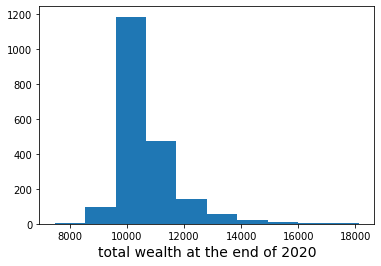

In [71]:
import matplotlib.pyplot as plt

plt.hist(each_sample_wealth)
plt.xlabel('total wealth at the end of 2020',fontsize=14)